<a href="https://colab.research.google.com/github/odunola25/MSC-project/blob/work/CNN_Brain_Tumour.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***Import Libraries***

In [ ]:
import os
import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

***Load Training and Testing Brain Tumour Images***

In [ ]:
train_path = '/content/drive/MyDrive/Colab Notebooks/Odunola Thesis/Brain Tumor MRI Dataset/Training'
test_path = '/content/drive/MyDrive/Colab Notebooks/Odunola Thesis/Brain Tumor MRI Dataset/Testing'

***Count the number of MRI Images in the training and testing set***

In [ ]:
def get_number(path):
  if not os.path.exists(path):
    return 0
  count = 0

  for current_path, dirs, files in os.walk(path):
    for dr in dirs:
      count += len(glob.glob(os.path.join(current_path,dr + "/*")))
  return count

In [ ]:
training_images = get_number(train_path)
testing_images = get_number(test_path)
num_classes = len(glob.glob(train_path + "/*"))

print("Number of classes is", num_classes)
print("Number of training samples is", training_images)
print("Number of testing samples is", testing_images)

Number of classes is 4
Number of training samples is 5722
Number of testing samples is 1311


***Data Augmentation***

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
    brightness_range = [0.8, 1.2],
    channel_shift_range = 50.0
    )

test_datagen = ImageDataGenerator(
    rescale=1./255
    )

In [ ]:
img_width, img_height = 224, 224
input_shape = (img_width, img_height, 3)
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (img_width, img_height),
    batch_size = batch_size)

test_generator = test_datagen.flow_from_directory(
    test_path,
    shuffle = False,
    target_size = (img_width, img_height),
    batch_size = batch_size)

Found 5722 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


***Build CNN Model for Brain Tumour Classification***

In [ ]:
model = Sequential()

# Convolutional layers with max pooling
model.add(Conv2D(32, (5, 5), input_shape=input_shape, activation='relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer to transition from convolutional to dense layers
model.add(Flatten())

# Fully connected (dense) layers with dropout for regularization
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))  # Dropout for regularization

model.add(Dense(128, activation='relu'))

# Output layer with 'num_classes' neurons and softmax activation for classification
model.add(Dense(num_classes, activation='softmax'))

# Display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2  (None, 73, 73, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 35, 35, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 78400)             0         
                                                                 
 dense (Dense)               (None, 512)               4

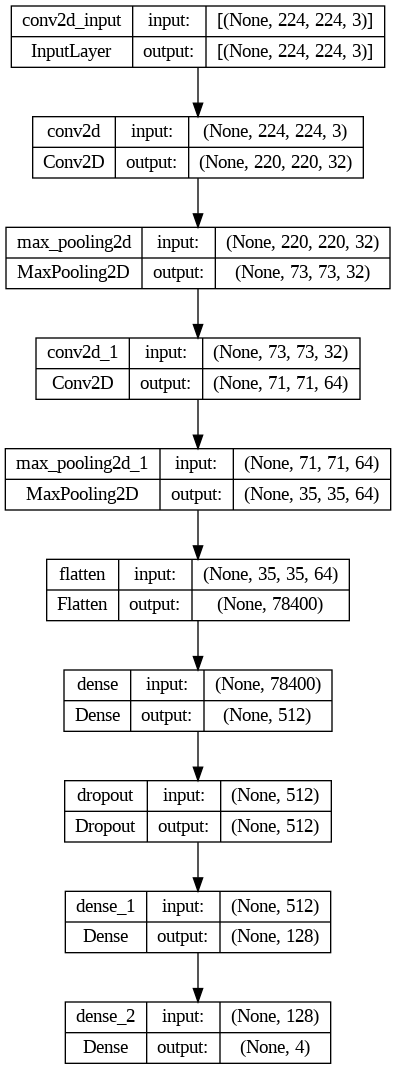

In [ ]:
# Plot the model architecture
from tensorflow.keras.utils import plot_model
from IPython.display import Image

plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

# Display the plot inline (in Jupyter Notebook or similar environments)
Image(filename='model.png')

In [ ]:
# Compile the model with a specified learning rate
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
#model.summary()

In [ ]:
best_model_path = '/content/drive/MyDrive/Colab Notebooks/Odunola Thesis/best_cnn_model_new.h5'

# Early stopping callback
early_stopping = EarlyStopping(monitor = 'val_accuracy', patience = 3, restore_best_weights = True, verbose = 1)

# Model checkpoint callback to save the best model
model_checkpoint = ModelCheckpoint(best_model_path, monitor = 'val_accuracy', save_best_only = True, verbose = 1)

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // train_generator.batch_size,
    validation_data = test_generator,
    validation_steps = test_generator.samples // test_generator.batch_size,
    epochs = 50,
    verbose = 1,
    callbacks = [early_stopping, model_checkpoint]  # Pass both callbacks
)

Epoch 1/50
178/178 [==============================] - ETA: 0s - loss: 1.2496 - accuracy: 0.3772
Epoch 1: val_accuracy improved from -inf to 0.42344, saving model to /content/drive/MyDrive/Colab Notebooks/Odunola Thesis/best_cnn_model_new.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


178/178 [==============================] - 1998s 11s/step - loss: 1.2496 - accuracy: 0.3772 - val_loss: 1.3555 - val_accuracy: 0.4234
Epoch 2/50
178/178 [==============================] - ETA: 0s - loss: 1.0623 - accuracy: 0.5234
Epoch 2: val_accuracy improved from 0.42344 to 0.50313, saving model to /content/drive/MyDrive/Colab Notebooks/Odunola Thesis/best_cnn_model_new.h5
178/178 [==============================] - 463s 3s/step - loss: 1.0623 - accuracy: 0.5234 - val_loss: 1.1815 - val_accuracy: 0.5031
Epoch 3/50
178/178 [==============================] - ETA: 0s - loss: 0.9927 - accuracy: 0.5664
Epoch 3: val_accuracy improved from 0.50313 to 0.54297, saving model to /content/drive/MyDrive/Colab Notebooks/Odunola Thesis/best_cnn_model_new.h5
178/178 [==============================] - 484s 3s/step - loss: 0.9927 - accuracy: 0.5664 - val_loss: 1.1323 - val_accuracy: 0.5430
Epoch 4/50
178/178 [==============================] - ETA: 0s - loss: 0.9467 - accuracy: 0.5889
Epoch 4: val_accur

In [ ]:
# Load the best model
best_model = tf.keras.models.load_model(best_model_path)

In [ ]:
# Evaluate the best model
test_loss, test_accuracy = best_model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy}')

41/41 [==============================] - 23s 553ms/step - loss: 0.8273 - accuracy: 0.6819
Test Accuracy: 0.681922197341919


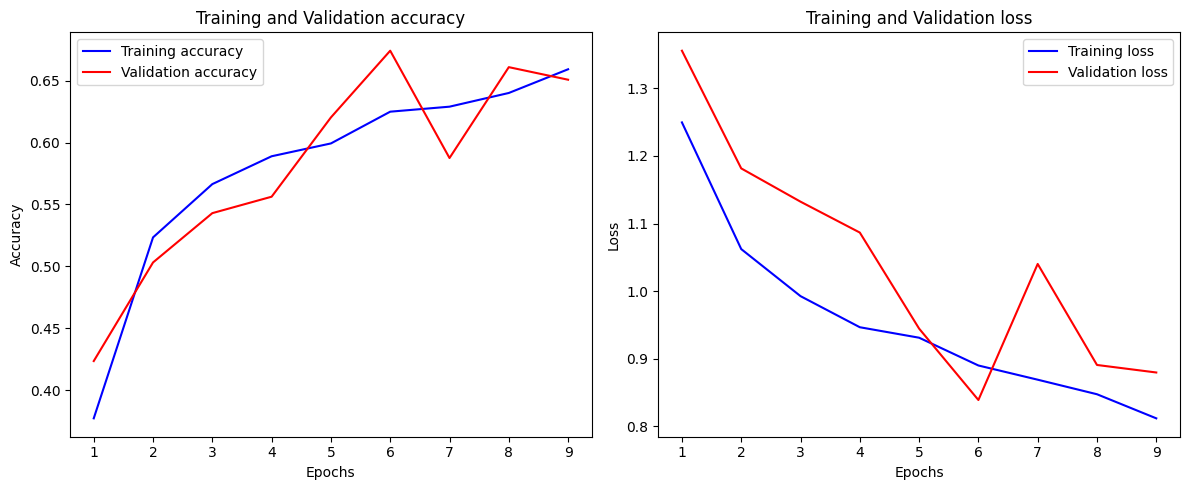

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Plotting Training and Validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)  # (rows, columns, panel number)
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting Training and Validation loss
plt.subplot(1, 2, 2)  # (rows, columns, panel number)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()  # Adjust the layout for better appearance
plt.show()

In [ ]:
Classes = ['Glioma', 'Meningioma', 'No Tumour', 'Pituitary']

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
y_test = test_generator.classes

# predicting our model with test dataset i.e. unseen dataset
pred = model.predict(test_generator, testing_images//batch_size+1,verbose=1,).argmax(axis=1)
#print(y_test)
print(pred)
#Classification report of every label
print(classification_report(y_test, pred, target_names = Classes))

41/41 [==============================] - 25s 588ms/step
[2 0 0 ... 3 3 3]
              precision    recall  f1-score   support

      Glioma       0.81      0.43      0.56       300
  Meningioma       0.57      0.36      0.44       306
   No Tumour       0.78      0.91      0.84       405
   Pituitary       0.59      0.95      0.73       300

    accuracy                           0.68      1311
   macro avg       0.69      0.66      0.64      1311
weighted avg       0.69      0.68      0.66      1311



In [ ]:
correct = 0
incorrect = 0
for i in range(len(y_test)):

    #print("Test Sample is: ", y_test[i], "while predicted sample is: ", pred[i])

    if y_test[i] != pred[i]:
        incorrect += 1
    else:
        correct += 1

print('Total number of test cases', ((len(y_test))))
print('Number of correct predictions', correct)
print('Number of incorrect predictions', incorrect)

Total number of test cases 1311
Number of correct predictions 894
Number of incorrect predictions 417


***Plot Confusion Matrix***

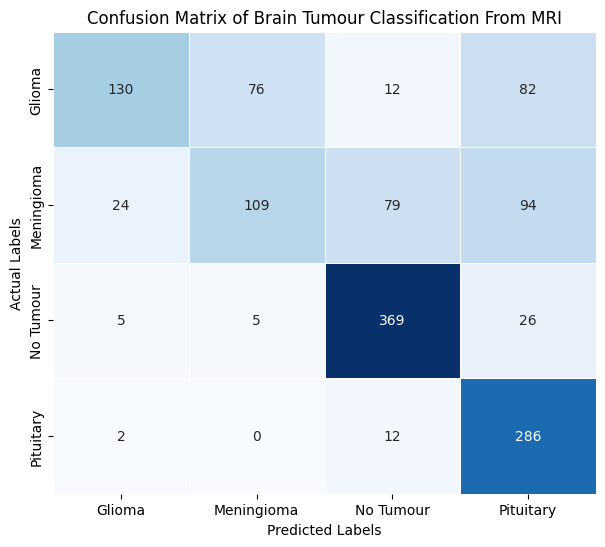

In [ ]:
import pandas as pd
import seaborn as sn

# Create a confusion matrix
conf_mat = confusion_matrix(y_test, pred)

# Create a DataFrame from the confusion matrix
conf_df = pd.DataFrame(conf_mat, columns = Classes, index = Classes)

# Plot the confusion matrix using seaborn with annotated actual and predicted labels
plt.figure(figsize = (7, 6))
plt.title('Confusion Matrix of Brain Tumour Classification From MRI')
sn.heatmap(conf_df, fmt = "d", cmap = "Blues", annot = True, cbar = False, linewidths = .5)

# Add x and y axis labels
plt.xlabel('Predicted Labels')
plt.ylabel('Actual Labels')

plt.show()